# Lab 3: Find my `Dream` Destination

**Building a Travel Planner with LangGraph using tools**

## Overview

In this lab we are going to create an Agent that will have access to tools to find a vacation destination. You will be able to ask this agent questions, watch it call the required tools, and have conversations with it. The lab will cover the following scenario:

#### What gets covered in this lab: 
we will cover these aspects below:
- Single Agent configuration
- Add `RAG` to the Agentic workflow
- Types of Agents
- Introduction to `Human-In-The-loop` concept
- `Multi-Modal` Agentic Chat

## Use case details
The agent is a travel chatbot assisting in finding the next best travel destination. We will create an agent capable of finding vacation destinations based on user's profile and travel history of similar users. This agent will have access to tool that can search based on available travel history data. We will have access to vector database to create similiar destinations

1. **Initial User Input**: 
   - User will ask for travel recommendation
   - Tool already has `user_id` to match with similar traveler profiles from historical data
  
2. **Provide additional details about suggested location**:
   - Use RAG tool to provide additional details about suggested location
  
3. **Human in the loop**:
   - Showcase tool execution based on human approval

### We can have 2 approaches which can be understood via this diagram below. 

- **Approach 1** we have an autonomous agent which is able to decide which tool to invoke (aka `Planners`) and also run the tool (aka `Solvers`)  till it gets the final answer. 
- **Approach 2** is where we have the agents deciding the next sequence of steps - but add a approval in the process before the tool gets run

we will also very briefly look at the 2 major Agent constructs `ReWoO and ReACT` agents

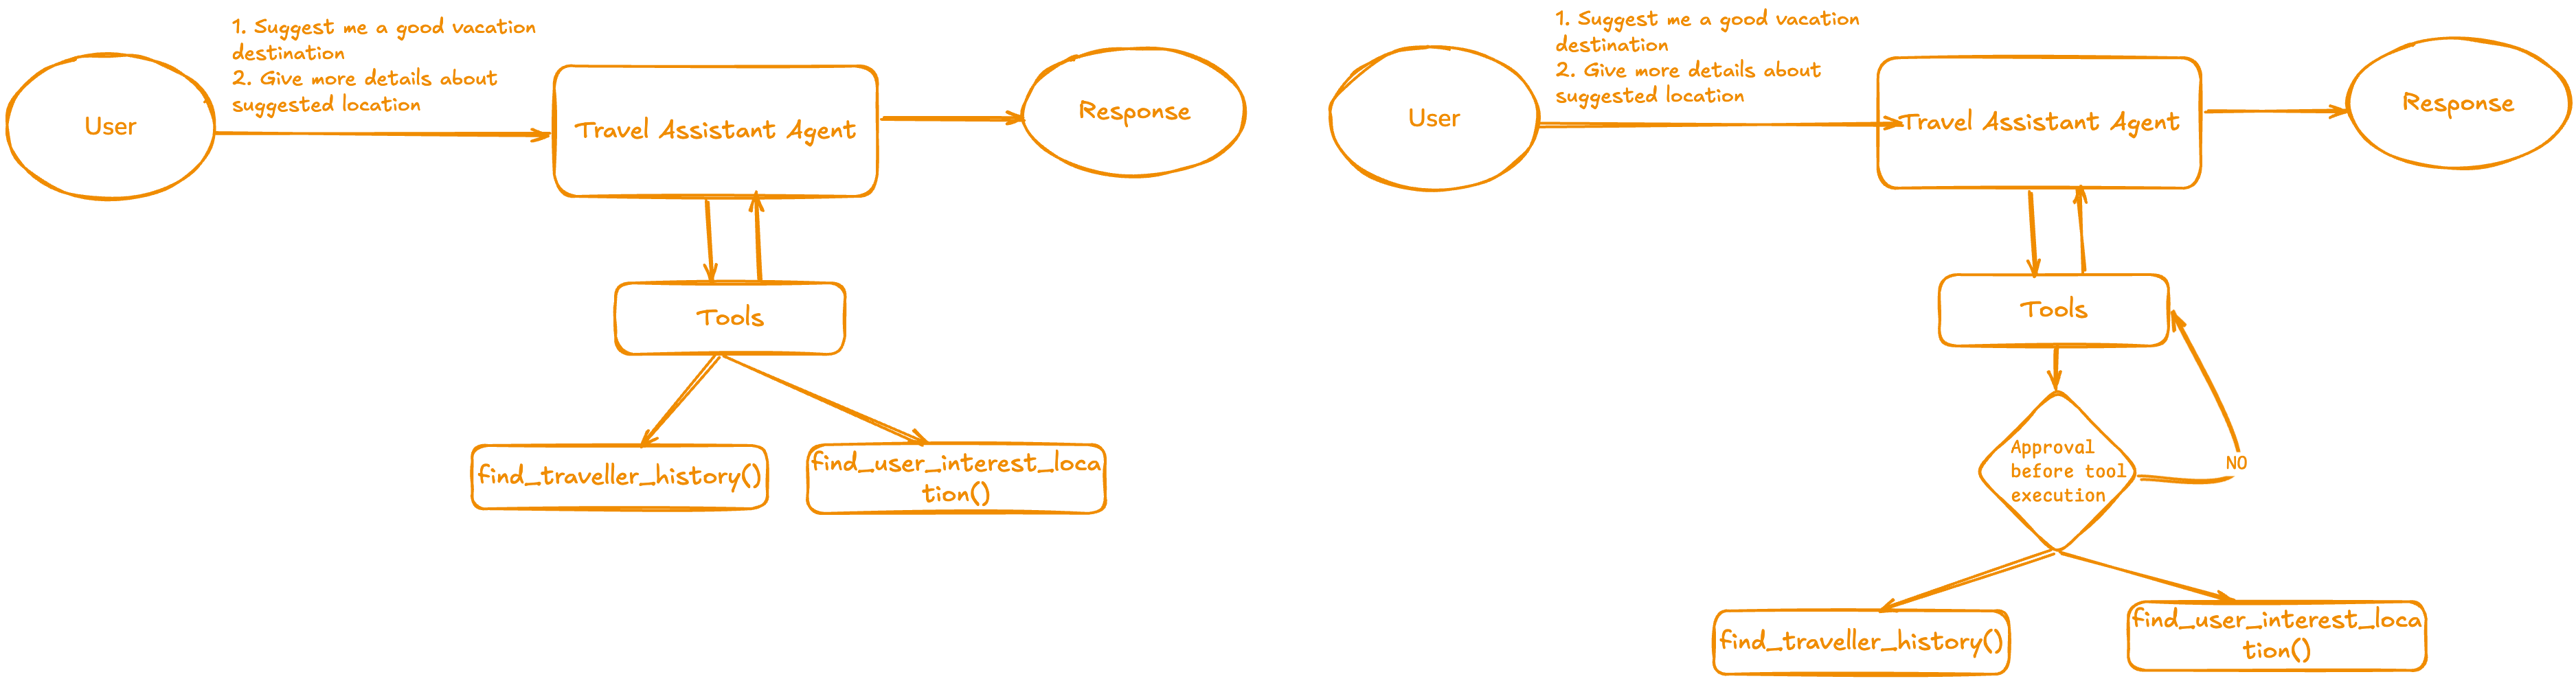

## Setup

Let's start with installing required packages. 

In [ ]:
# %pip install -U --no-cache-dir  \
# "langchain==0.3.7" \
# "langchain-aws==0.2.6" \
# "langchain-community==0.3.5" \
# "langchain-text-splitters==0.3.2" \
# "langchainhub==0.1.20" \
# "langgraph==0.2.45" \
# "langgraph-checkpoint==2.0.2" \
# "langgraph-sdk==0.1.35" \
# "langsmith==0.1.140" \
# "pypdf==3.8,<4" \
# "ipywidgets>=7,<8" \
# "matplotlib==3.9.0" \
# "faiss-cpu==1.8.0" \
# "pandas==2.2.3"

### Agents

An AI agent is a software program or system that uses artificial intelligence techniques to perceive its environment, make decisions, and take actions to achieve specific goals. These agents are designed to operate with some degree of autonomy and can adapt their behavior based on their experiences and the information they receive. Their capabilities extend beyond simple interactions, enabling them to engage in complex decision-making, problem-solving, and task execution with or without human intervention

**Key characteristics of AI agents include:**

**Perception:** The ability to gather information from their environment through sensors or data inputs.
**Decision-making:** Using AI algorithms to process information and determine the best course of action.
**Action:** The capability to execute decisions and interact with the environment or users.
**Learning:** The ability to improve performance over time through experience and feedback.
**Autonomy:** Operating independently to some degree, without constant human intervention.
**Goal-oriented:** Working towards specific objectives or tasks.


LLM's are great with Classification problems and this has enabled `Agents` to be a reality

We create a Bedrock client that is used to configure LLM in LangChain to use Bedrock.

In [14]:
from langchain_aws import ChatBedrock
import boto3

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")

## Language Model

The LLM powering all of our agent implementations in this lab will be Claude 3 Sonnet via Amazon Bedrock. For easy access to the model we are going to use `ChatBedrockConverse` class of LangChain, which is a wrapper around Bedrock's Converse API. 

In [15]:
from langchain_aws import ChatBedrockConverse

llm = ChatBedrockConverse(
    model = "anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

# Build a first travel recommendation agent 

## Tools

Let's create tools that will be used by our agents to find a vacation destination based on user' profile and travel history of similar users.

Tools are external resources, services, or APIs that an LLM agent can access and utilize to expand its capabilities and perform specific tasks. These supplementary components allow the agent to go beyond its core language processing abilities, enabling it to interact with external systems, retrieve information, or execute actions that would otherwise be outside its scope. By integrating tools, LLM agents can provide more comprehensive and practical solutions to user queries and commands.

A tool consists of:

- The name of the tool.
- A description of what the tool does.
- A JSON schema defining the inputs to the tool.
- A function (and, optionally, an async variant of the function)

in LangGraph Tools can be specified by decorating them with the ```@tool``` decorator. This parses the respective function name as well as docstrings and input parameters into a name, description and interface definition. When a tool is bound to a model, this information is provided as context to the model. Given a list of tools and a set of instructions, a model can figure out how to call one or more tools with specific inputs as well as when to call which tool. 

We will create a tool that uses historic travel information of different users to find a vacation destination based on user' profile and travel history of similar users. The tool will use the local csv file to retrieve historical data about travel destinations. It will then analyze the data and return the most popular destination for the user.

###  Dataset
we have 2 data sets which we will use 
- First data set we will be using consists of these key columns  `Id`, `Current_Location`, `Past_Travel_Destinations`, `Number_of_Trips`, `Arrival_City` and others.... These will be ingested in the RAG system to help us create Similiar destinations. These are just a sample for this workshop. You would probably have other details like `Activities`, `Comments` etc which can be used by the Agent to find like destinations, provide details about location and activities 
- Matching similiar cities and activities via `semantic` searches leveraging vector store. These consist of details about `cities` including famous travel spot on those cities

we will find the cities which the user can travel and then use that to find other `similiar` destinations using the vector store



let us add our 1st tool

In [18]:
import pandas as pd
from collections import Counter
from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig


def read_travel_data(file_path: str = "data/synthetic_travel_data.csv") -> pd.DataFrame:
    """Read travel data from CSV file"""
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        return pd.DataFrame(
            columns=["Id", "Name","Current_Location","Age","Past_Travel_Destinations", "Number_of_Trips", "Flight_Number", "Departure_City","Arrival_City","Flight_Date",]
        )


@tool
def compare_and_recommend_destination(config: RunnableConfig) -> str:
    """This tool is used to check which destinations user has already traveled.
    Use name of the user to fetch the information about that user.
    If user has already been to a city then do not recommend that city.

    Returns:
        str: Destination to be recommended.

    """

    df = read_travel_data()
    user_id = config.get("configurable", {}).get("user_id")

    if user_id not in df["Id"].values:
        return "User not found in the travel database."

    user_data = df[df["Id"] == user_id].iloc[0]
    current_location = user_data["Current_Location"]
    age = user_data["Age"]
    past_destinations = user_data["Past_Travel_Destinations"].split(", ")

    # Get all past destinations of users with similar age (±5 years) and same current location
    similar_users = df[(df["Current_Location"] == current_location) & (df["Age"].between(age - 5, age + 5))]
    all_destinations = [dest for user_dests in similar_users["Past_Travel_Destinations"].str.split(", ") for dest in user_dests ]

    # Count occurrences of each destination
    destination_counts = Counter(all_destinations)

    # Remove user's current location and past destinations from recommendations
    for dest in [current_location] + past_destinations:
        if dest in destination_counts:
            del destination_counts[dest]

    if not destination_counts:
        return f"No new recommendations found for users in {current_location} with similar age."

    # Get the most common destination
    recommended_destination = destination_counts.most_common(1)[0][0]

    return f"Based on your current location ({current_location}), age ({age}), and past travel data, we recommend visiting {recommended_destination}."

The second tool we want to add to our travel recommendation agent is a retrieval tool. The retrieval tool will allow the agent to access and utilize external information, enhancing its knowledge base. We have synthetic data about few cities in the world. We'll use this data to populate our knowledge base with additional information about each city.

In this section, we prepare our retriever:

We will use the pickle files that are already prepared with vector store

the Vector store process can be similiar to the diagram below

<img src="./images/RAG-travellers.png" width="40%">


In [19]:
from langchain_aws.embeddings.bedrock import BedrockEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.retrievers import ParentDocumentRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter

# import faiss
from io import BytesIO
import pickle

embeddings_model = BedrockEmbeddings(
    client=bedrock_client, model_id="amazon.titan-embed-text-v1"
)

child_splitter = RecursiveCharacterTextSplitter(
    separators=["\n", "\n\n"], chunk_size=2000, chunk_overlap=250
)

in_memory_store_file = "data/section_doc_store.pkl"
vector_store_file = "data/section_vector_store.pkl"

store = pickle.load(open(in_memory_store_file, "rb"))
vector_db_buff = BytesIO(pickle.load(open(vector_store_file, "rb")))
vector_db = FAISS.deserialize_from_bytes(
    serialized=vector_db_buff.read(),
    embeddings=embeddings_model,
    allow_dangerous_deserialization=True,
)

retriever = ParentDocumentRetriever(
    vectorstore=vector_db,
    docstore=store,
    child_splitter=child_splitter,
)

We now create a specialized retrieval tool using the `create_retriever_tool` function from LangChain:

1. The tool is based on our previously set up retriever.
2. We name it "search_user_interest".
3. Its description specifies that it searches through multiple PDF documents containing city details.
4. The tool is designed to find information that matches the user's interests in various cities.
5. It's instructed to search based only on the keywords mentioned in the user's input.


In [20]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "search_user_interest",
    "Searches through multiple PDF documents containing city details to find information matching the user's interests in various cities. Only search based on the keyword mentioned in user input.",
)

Now we also add both tools to the list of tools our agent will be able to use.

In [21]:
tools = [compare_and_recommend_destination, retriever_tool]

## Let us dive into Approach 1

#### Types of Agents

Agents have 2 main constructs - `Planners` who create a detailed plan for task execution and then `Solvers` who executes the planned steps and Integrates outputs from executed tasks to formulate a final response. These 2 work hand-in-hand to execute a particular task. This implies:

Broadly we have 2 types of agents
- **ReWoO / ROC agents**: These are agents who are `aware of the tools` but return the control back to the user. The ReWoo technique optimizes performance by generating a complete task plan up front and executing it without checking intermediate outputs, as shown in Figures below. It saves on over all latency as it miminizes model call. It is exceptionally good for `A-Sync` execution or for `confirmations/ human interventions` and others. In here the Agent will return the **entire plan of execution** back to the calling application as in invoke this tool followed by this etc. However this needs a very complex prompt. Further if the output were to impact the steps order, this strategy will not take that into account and fail.
- **ReACT agents** : These are agents which `react` to the stimulus which can be tool completion, user input, model responses, tool invocation  and others. Default ReAct strategy requires at least N+1 calls to the model for N steps. However this is simpler to execute and provides flexibility using the dynamic tool selection based on the output of the previous responses. For most use cases this wil lbe the default.



<img src="./images/ReACT_agents.png" width="35%" alt='multi_memory_light.png' />  | <img src="./images/ReWoO_agents.png" width="30%" alt='multi_memory_light.png' />  | 

Steps in a ReACT agents

<img src="./images/agent_action_thought.png" width="15%" alt='multi_memory_light.png' /> 


#### Create a ReWoO agent for finding a good destination

Langgraph provides an easy mechanism which is `bind_tools` to the LCEL chain to allow us ot create agents which return control back to the user. In here the Agents provides detais of which function and what parameters to pass to that function. It is up to the invoking aplication to call the function, add the response back to the prompt and invoke the model again. These are typically useful for `A-Sync` workflows or where we might need `Human-in-the-loop`

For any `multi-step` workflows where we need to invoke multiple tools like in this case, it can be significant overhead to create a running loop and continue till we have the `stop sequence` as final answer from the model. 

<class 'langchain_core.runnables.base.RunnableBinding'>


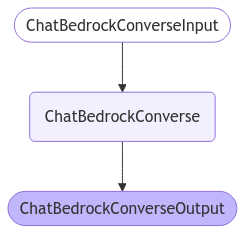

In [22]:
from IPython.display import Image, display

rewoo_agent = llm.bind_tools(tools)
print(type(rewoo_agent))
display(Image(rewoo_agent.get_graph().draw_mermaid_png()))

In [24]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"user_id": 9188}}

response_rewo = rewoo_agent.invoke([HumanMessage(content="Suggest me a good vacation destination.")],config)
print("--------")
print("Full trace:")
print(type(response_rewo))
print("--------")
print("Final response:")
for one_message in response_rewo.content:
    if isinstance(one_message, dict)  and one_message['type'] == 'tool_use':
        print(f"LLM Responded with Tool call = {one_message['name']}()::params = {one_message['input']}")
print("--------\n Now the Application running this can invoke the tool, pass the results back to the LLM and the process continues")

--------
Full trace:
<class 'langchain_core.messages.ai.AIMessage'>
--------
Final response:
LLM Responded with Tool call = compare_and_recommend_destination()::params = {'user_name': 'user'}
--------
 Now the Application running this can invoke the tool, pass the results back to the LLM and the process continues


#### Create a ReACT Agent

For any `multi-turn` and `multi-step` workflows we have to either create or leverage the `ReACT` agents. Now that we have defined the tools and the LLM, we can create the agent. LangGraph comes with pre-built higher level APIs for common agent scenarios. These higher level APIs cover a lot of the heavy lifting when constructing our StateGraph for our agent use cases. For  Approach 1 we will be using such a high level API to construct the agent and it's StateGraph. Later for Approach 2 we will use lower level APIs and rebuild what the higher level API is doing under the hood. 

Let's start with initializing the agent with the LLM and the tools.

Here we are leveraging the `user ID` which is being passed via the config to sugest `similiar destinations` based on the travel history. This diagrams explains the call

<img src="./images/react_tool_call.png" width="15%"  height="15%" alt='multi_memory_light.png' /> 

In [25]:
from langgraph.prebuilt import create_react_agent

react_agent = create_react_agent(llm, tools)
type(react_agent)

langgraph.graph.state.CompiledStateGraph

The ```create_react_agent```funtion returned a ```CompiledStateGraph``` object. Let's visualize this graph.

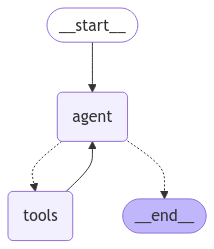

In [26]:
from IPython.display import Image, display

display(Image(react_agent.get_graph().draw_mermaid_png()))

We are ready to test our agent with a sample input!

we wil notice the agents will make the `multiple` tool call in the below print statements something like this below. Notice it will pass in the user_id like this sample shows 
{'type': 'tool_use', 'name': 'compare_and_recommend_destination', 'input': {'user_name': 'user'}, 'id': 'tooluse_vKrc'}]

The agent if first calling the ```compare_and_recommend_destination``` tool to recommend a destination. Then, it is calling the ```search_user_interest``` tool to figure out more information about the suggested destination through RAG so it can provide an answer with grounded facts.

The complete chronology of actions behind the scene is as follows: 

1. User asks for a travel vacation recommendation
2. The LLM uses compare_and_recommend_destination tool to analyze user's profile (location, age, and past travel data) and suggests a location
3. The LLM then uses search_user_interest tool to gather more information about the location
4. Based on the search results, the LLM provides a detailed response, highlighting the location's attractions, which are extracted of the pdf documents that are used to create retriever.

In [ ]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"user_id": 918}}

response = react_agent.invoke({"messages": [HumanMessage(content="Suggest me a good vacation destination.")]},config)

print("--------")
print("Full trace:")
for one_message in response["messages"]:
    print(one_message.pretty_print())
print("--------")
print("Final response:")
print(response["messages"][-1].pretty_print())
print("--------")

--------
Full trace:
content='Suggest me a good vacation destination.' additional_kwargs={} response_metadata={} id='c974c28b-e6e8-4db1-9e2b-fad4a343f42b'
content=[{'type': 'text', 'text': "Okay, let's try to find a good vacation destination for you. "}, {'type': 'tool_use', 'name': 'compare_and_recommend_destination', 'input': {'user_name': 'user'}, 'id': 'tooluse_PdllNenBQG-tvVDxcOzGqg'}] additional_kwargs={} response_metadata={'ResponseMetadata': {'RequestId': '9d48ce7e-8e9b-4412-adca-773dbdd0374a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 20 Nov 2024 19:32:26 GMT', 'content-type': 'application/json', 'content-length': '375', 'connection': 'keep-alive', 'x-amzn-requestid': '9d48ce7e-8e9b-4412-adca-773dbdd0374a'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 613}} id='run-c6ee2950-3035-4c3a-8d81-b275a9fc12e8-0' tool_calls=[{'name': 'compare_and_recommend_destination', 'args': {'user_name': 'user'}, 'id': 'tooluse_PdllNenBQG-tvVDxcOzGqg', 'type':

### Build a customized ReAct Chain

**Again as part of Approach 1** we will explore the `Graph` or `DAG` concepts to provide determinism when creating our agents. This approach will give us greater control on which tool to call and how. So far we have seen that LLM is able to decide which tool it has to use. 

**But what if we need more control to move from one node to other. What if tool does not have all the inputs to execute the function?  What if we want to directly return the output of the tool?**

In this section, we'll explore how to create a more customized and transparent agent using LangGraph. We'll now dive deeper to gain more control over the agent's decision-making process and tool usage.

### Agent State

The graph we will be building further down is `parameterized`by a state object that is passed around to each node during graph execution for keeping the state. Each node updates this state during invocation.

In this example we want each node to add messages to the message list. Therefore, we define a TypedDict with one key (messages) as State. To accumulate the message history we specify the add_messages operator for updates. 

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, MessagesState
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

#### Create the Agent¶ using the 
- LCEL chain
- bind_tools()

Define the assistant function. This function takes the graph state, formats it into a prompt, and then calls an LLM for it to predict the best response.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant capable of providing travel recommendations."
            " Use the provided tools to look for personalized travel recommendations and information about specific destinations."
            " `compare_and_recommend_destination` has information about user. Use this tool to get recommendation"
            " If you dont have enough information then use AskHuman tool to get required information. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up.",
        ),
        ("placeholder", "{messages}"),
    ]
)


llm = ChatBedrockConverse(
    # model="anthropic.claude-3-sonnet-20240229-v1:0",
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

runnable_with_tools = primary_assistant_prompt | llm.bind_tools(tools)

def call_model(state: State, config: RunnableConfig):
    response = runnable_with_tools.invoke(state)
    return {"messages": [response]}

####  Graph build


In our case we need to define a conditional edge that routes to the ```ToolNode``` when a tool get called in the agent node, i.e. when the LLM determines the requirement of tool use. With ```tools_condition```, LangGraph provides a pre-implemented function which is able to hanle this. Further, an edge from the ```START```node to the ```assistant```and from the ```ToolNode``` back to the ```assistant``` are required.

We are adding the nodes, edges as well as a persistant memory to the ```StateGraph``` before we compile it. 

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)


# Define nodes: these do the work
graph_builder.add_node("travel_planner", call_model)
graph_builder.add_node("tools", ToolNode(tools=tools))  
# Define edges: these determine how the control flow moves
graph_builder.add_edge(START, "travel_planner")
graph_builder.add_conditional_edges(
    "travel_planner",
    tools_condition,
)
graph_builder.add_edge("tools", "travel_planner")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
travel_planner_agent = graph_builder.compile(checkpointer=memory)

Let's take a look into a visual representation of our compiled state graph.

In [ ]:
from IPython.display import Image, display

display(Image(travel_planner_agent.get_graph().draw_mermaid_png()))

Its time to test our compiled graph. We can use the input the we have used before

> Suggest me a good vacation destination.  --- pass in the user id of 709

In [ ]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "4", "user_id": 709}}

input_message = HumanMessage(
    content="Suggest me a good vacation destination."
)
for event in travel_planner_agent.stream(
    {"messages": [input_message]}, config, stream_mode="values"
):
    event["messages"][-1].pretty_print()

# Interactive agentic flows, `Human-In-The-loop` - Approach 2
**interact with a user during execution time for additional inputs**

Sometimes, additional input might be required to execute a tool or to solve a higher level task. Or we might need confirmations before we cab execute some critical functions. In this case, we need to return control back to the user to collect human feedback. 

In LangGraph this can be implemented through a breakpoint-like concept: we stop graph execution at a specific step. At this breakpoint, we can wait for human input. Once we have input from the user, we can add it to the graph state and resume execution. In what follows, we will extend our agentic assistant to support user interaction through ReWoO / return of control. Production systems will typically use the `interrupt_before` feature where the graph temporarily pauses the execution and returns an ID back. You can read up more on this [here]('https://github.com/langchain-ai/langgraph/blob/main/docs/docs/how-tos/human_in_the_loop/wait-user-input.ipynb')


However we will use a MemorySaver for purposes of this workshop to simulate that.

### Interrupt for approval

We're building a system that handles various hotel management operations like suggesting hotels, retrieving bookings, modifying reservations, and processing cancellations. A key requirement is to implement human approval for sensitive operations (changes and cancellations) while allowing other operations to proceed automatically. This creates a natural division in our workflow between operations that can proceed automatically and those requiring human oversight.

We can have two approaches to implementing this:

| Approach | Description | Pros | Cons |
|----------|-------------|------|------|
| **Custom Tool Node** | Based on the prompt, this is a single flow where human approval is handled through prompt engineering. System determines approval needs based on operation type within prompt. |  More streamlined graph structure with fewer nodes |  Higher risk of prompt misinterpretation |
| | |  More flexible to add/remove human approval requirements without changing graph structure |  Could be more challenging to debug prompt-related issues |
| **Separated Node Approach** | Separates workflow into two distinct paths - one for routine operations and another for sensitive operations requiring approval. |  Deterministic workflow in the graph |  More state management overhead |
| | |  Clear separation of concerns between safe and approval-requiring operations |  More complex graph structure |

<img src="./images/human-in-the-loop.png" width="45%"  alt='multi_memory_light.png' /> 

We will demostrate Custom Tool Nodel approach and leverage that in our workshop


<div class="alert alert-block alert-info">
<b>Note:</b> Please check the example in `DO_NOT_run` notebook to check graph state interruption example
</div>

### Custom Tool Node for Human Approval

- Custom approval node that gates access to sensitive operations
- Synchronous human input collection
- Direct tool execution after approval
- Linear workflow without complex state management

In [ ]:
import json

from langchain_core.messages import ToolMessage


class HumanApprovalToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            user_input = input("Do you approve of the above actions? Type 'y' to continue;"" otherwise, explain your requested changed.\n\n")
            if user_input.lower() == "y":
                tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])
                outputs.append(ToolMessage(content=json.dumps(tool_result),name=tool_call["name"],tool_call_id=tool_call["id"],))
            else:
                outputs.append(ToolMessage(content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",name=tool_call["name"],tool_call_id=tool_call["id"],))
        return {"messages": outputs}


#### Compile the graph

We can noe compile the graph again but instead of using pre-built `ToolNode` we will use the `HumanApprovalToolNode`that we have created for human approval

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)


# Define nodes: these do the work
graph_builder.add_edge(START, "travel_planner")
graph_builder.add_node("travel_planner", call_model)
graph_builder.add_node("tools", HumanApprovalToolNode(tools=tools))

# Define edges: these determine how the control flow moves
graph_builder.add_conditional_edges(
    "travel_planner",
    tools_condition,
)

graph_builder.add_edge("tools", "travel_planner")


# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
agent_with_hil = graph_builder.compile(checkpointer=memory)

Let's take a look into a visual representation of our compiled state graph.

In [ ]:
from IPython.display import Image, display

display(Image(agent_with_hil.get_graph().draw_mermaid_png()))

Let's test it out!

When you run this cell you will see an `input` prompt asking for confirmation like 'Do you approve of the above actions? Type 'y' to continue;' Please enter y to continue

In [ ]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "10", "user_id": 118}, "recursion_limit": 10,}

input_message = HumanMessage(content="Suggest me a good vacation destination.")
for event in agent_with_hil.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

## Multimodal agent

Let's look at the scenario where we can also process images as an input to our agent. We will create an agent capable of processing and analyzing images using Claude 3 Haiku, Anthropic's fastest multimodal model. 

The workflow is simple - users upload an image of a place they'd love to visit, and our agent springs into. Using Claude 3 Haiku's vision capabilities, it identifies the city or landmark in the image. Then, it taps into a custom retriever tool containing rich information about various cities to provide detailed insights about the destination.


Let's reuse the retriever we have created above. We will only update the tool name and description to make sure model is able to use it properly. 

we will use this image to ask the Agentic system to recomend destinations

<img src="./images/amsterdam.jpeg" width="25%" alt="amsterdam created by Bedrock" />


In [28]:
city_info_retriever_tool = create_retriever_tool(
    retriever,
    "city_info_retriever_tool",
    "Searches through multiple PDF documents containing city details to find information matching the user's interests in various cities.",
)

In [29]:
model_with_tools = llm.bind_tools([city_info_retriever_tool])
dream_destination_agent = create_react_agent(llm,tools=[city_info_retriever_tool,])

Here we'll do a multi-modal search using our `dream_destination_agent` tool. Remember, if you get an like the following, ensure you've requested model access to the `Titan model` we're using for embeddings: This is incase you see an error like this --- > An error occurred (AccessDeniedException) when calling the InvokeModel operation: You don't have access to the model with the specified model ID.

{'messages': [HumanMessage(content=[{'type': 'text', 'text': 'Give more details about the city'}, {'type': 'image_url', 'image_url': {'url': ''}}], additional_kwargs={}, response_metadata={}, id='fad65dd2-692c-4f3b-a46b-d9139a8441b6'),
  AIMessage(content=[{'type': 'tool_use', 'name': 'city_info_retriever_tool', 'input': {'query': 'Amsterdam'}, 'id': 'tooluse_c1zp0SIoTomXnoHJmzwsEA'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'b1327547-4dee-4388-b6ab-2c45cc9e4cfd', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 20 Nov 2024 20:42:47 GMT', 'content-type': 'application/json', 'content-length': '297', 'connection': 'keep-alive', 'x-amzn-requestid': 'b1327547-4dee-4388-b6ab-2c45cc9e4cfd'}, 'RetryAttempts': 1}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 1647}}, id='run-a562dd42-32ad-4d70-b32f-aafeb3fd743e-0', tool_calls=[{'name': 'city_info_retriever_tool', 'args': {'query': 'Amsterdam'}, 'id': 'tooluse_c1zp0SIoTomXnoHJmzwsEA', 'type': 'tool_ca
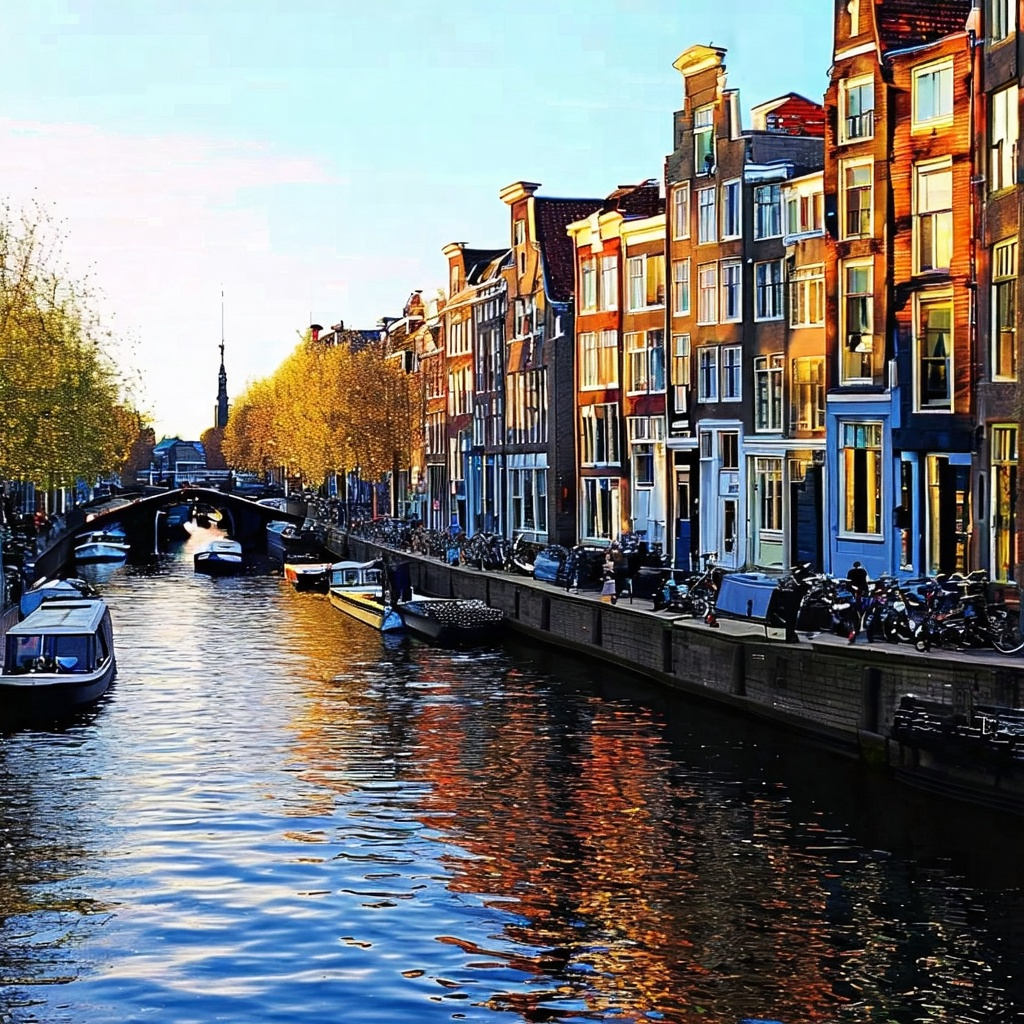

In [ ]:
import base64

image_url = "images/amsterdam.jpeg"
with open(image_url, 'rb') as image_file:
    image_data = base64.b64encode(image_file.read()).decode("utf-8")
    
message = HumanMessage(
    content=[
        {"type": "text", "text": "Give more details about the city"},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        },
    ],
)
result_msg = dream_destination_agent.invoke({"messages": [message]})['messages']
result_msg[-1].pretty_print()

# - un comment if you want to see the whole sequence of calls, just be aware this will  print the base 64 encoded image string as well -- 
# print(result_msg)#


#### Let us see what our Vector store returned from this Image

In [ ]:
for i in result_msg:
    if type(i) == ToolMessage:
        print(i.content)
        break

Here you can see that the agent correctly searched using an image of amsterdam and returned information about it from our vector store. 

# Congratulations

You have successfully finished this lab. You can now move over to the next one!